# Welcome to the Forward Simulation tutorial
In this tutorial, we will bring together all the knowledge you have acquired so far and guide you through running your first model. This involves creating a fracture geometry, creating an antenna configuration for the source and receivers, setting up your source function and running the forward simulation. We will also show you how to visualize the geometry configuration and the results of the simulation. 
### Contents:
1. [Create a source function](#1)
2. [Create a simple geometry](#2)
3. [Create an antenna geometry](#3)
4. [Visualize the geometry configuration](#4)
5. [Setup the parameters for the forward simulation](#5)
6. [Time zero correction](#6)
7. [Run the forward simulation](#7)
8. [Check results](#8)
9. [Save the results](#9)

In [88]:
 # Import all the important pakages
from fracwave import FractureGeo, Antenna, SourceEM, FracEM, OUTPUT_DIR
import numpy as np
import matplotlib.pyplot as plt


## 1. Create a source function <a class="anchor" id="1"></a>
It's crucial to define a source function as it directly impacts the required element size in your simulation. The characteristics of the source function will influence the level of detail necessary to achieve accurate results. Hence, understanding and specifying the source function is of paramount importance in your simulation setup.


In [93]:
sou2 = SourceEM()
sou2.load_hdf5(OUTPUT_DIR + 'source_function.h5')
print(sou2)
#sou2.export_to_hdf5(OUTPUT_DIR + 'source_function.h5', overwrite=True)
sou2.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)

2025/10/22 12:25:32 PM | INFO     | Loaded successfully

        EM SourceEM  2025-10-22 12:25
        
        Type of source: ricker
        
        Frequency:
            nfrequencies: 1001
            Sampling frequency: 19.97 GHz
            Nyquist frequency: 9.98 GHz 
            delta f: 9.98 MHz / sample
            Central frequency: 1.00 GHz
            
        Time:
            nsamples: 2001 
            Time Window: 100.16 ns
            delta t: 0.05 ns / sample
            Time delay: 50 ns
            
2025/10/22 12:25:32 PM | INFO     | Overwriting existing "source" information
2025/10/22 12:25:32 PM | INFO     | File successfully saved in: c:\users\afsal\pycharmprojects\pythonproject14\fracwave\output\FW_sim.h5


In [94]:
# We will define that the maximum element size is a fourth of the wavelength from our source function
c0 = 299_792_458  # Speed of light in m/s
rock_epsilon = 9  # Relative permitivity of the medium (dielectric constant)
velocity = c0 * 1e-9 / np.sqrt(rock_epsilon)  # To convert in m/ns
max_element_size = velocity / (sou2.center_frequency * 4)
print(f'Element max size = {max_element_size:.2f} m')

Element max size = 0.02 m


## 2. Create a simple geometry <a class="anchor" id="2"></a>

In [95]:
# Create a simple geometry
frac = FractureGeo()
ver, _ = frac.create_regular_squared_mesh(width=1,
                                 length = 1,
                                 resolution = (10,10),
                                 dip = 90,
                                 azimuth = 180,
                                 center = (0,0.5,0),
                                 ) 

plane = 1
grid, vertices, faces = frac.remesh(points=ver,
                                    max_element_size=max_element_size,
                                   plane=plane)


2025/10/22 12:25:57 PM | INFO     | Fracture object loaded
2025/10/22 12:25:57 PM | DEBUG    | horizontal resolution too big (10) setting to 41 ...
2025/10/22 12:25:57 PM | DEBUG    | vertical resolution too big (10) setting to 41 ...
2025/10/22 12:25:57 PM | DEBUG    | Meshing to resolution: [41, 41]...
2025/10/22 12:25:58 PM | DEBUG    | Meshing done
2025/10/22 12:25:58 PM | DEBUG    | Extracting vertices and faces...
2025/10/22 12:25:58 PM | DEBUG    | Extract done


2025/10/22 12:26:03 PM | DEBUG    | Faces set
2025/10/22 12:26:03 PM | DEBUG    | Vertices set
2025/10/22 12:26:03 PM | DEBUG    | Fracture Fracture1 set

        Fracture Geometry  2025-10-22 12:25
            number of fractures: 1
            number of elements: 1600
            surface area: 1.00 (m2)
        


c:\users\afsal\pycharmprojects\pythonproject14\fracwave\fracwave\plot\geometry_plot.py:75: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([vertices[:,1].min(), vertices[:,1].max()])


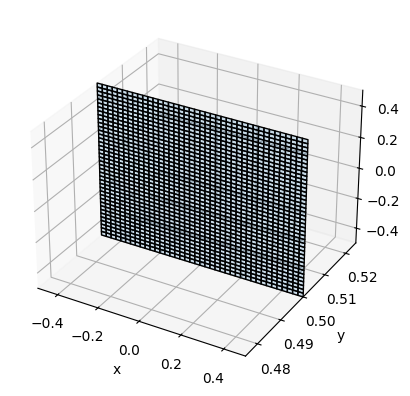

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

In [96]:
kwargs_electric_properties = dict(aperture=0.1, # in m
                                  electrical_conductivity=0, # in S/m
                                  electrical_permeability=81)  # Unitless
frac.set_fracture(name_fracture='Fracture1',
                  vertices=vertices,
                  faces=faces,
                  overwrite=True,
                  plane=plane,
                  **kwargs_electric_properties,)
print(frac)
frac.plot_geometry(backend='mpl')

In [97]:
frac.fractures.head()

,x,y,z,azimuth,dip,area,aperture,elec_permeability,elec_conductivity,faces,vertices,nz,name,index,plane,nx,ny
0,-0.48750,0.50000,-0.48750,0.00000,90.00000,0.00062,0.10000,81,0,"[0, 1, 42, 41]","[[-0.5, 0.5, -0.5], [-0.5, 0.5, -0.475], [-0.4...","[0.0, 1.0, 0.0]",Fracture1,0,1,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]"
1,-0.48750,0.50000,-0.46250,0.00000,90.00000,0.00062,0.10000,81,0,"[1, 2, 43, 42]","[[-0.5, 0.5, -0.475], [-0.5, 0.5, -0.45], [-0....","[0.0, 1.0, 0.0]",Fracture1,1,1,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]"
2,-0.48750,0.50000,-0.43750,0.00000,90.00000,0.00062,0.10000,81,0,"[2, 3, 44, 43]","[[-0.5, 0.5, -0.45], [-0.5, 0.5, -0.425], [-0....","[0.0, 1.0, 0.0]",Fracture1,2,1,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]"
3,-0.48750,0.50000,-0.41250,0.00000,90.00000,0.00062,0.10000,81,0,"[3, 4, 45, 44]","[[-0.5, 0.5, -0.425], [-0.5, 0.5, -0.4], [-0.4...","[0.0, 1.0, 0.0]",Fracture1,3,1,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]"
4,-0.48750,0.50000,-0.38750,0.00000,90.00000,0.00062,0.10000,81,0,"[4, 5, 46, 45]","[[-0.5, 0.5, -0.4], [-0.5, 0.5, -0.375], [-0.4...","[0.0, 1.0, 0.0]",Fracture1,4,1,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]"


In [98]:
frac.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)

2025/10/22 12:26:20 PM | INFO     | Overwriting existing "mesh" information
2025/10/22 12:26:20 PM | INFO     | File successfully saved in: c:\users\afsal\pycharmprojects\pythonproject14\fracwave\output\FW_sim.h5


## 3. Create an antenna geometry <a class="anchor" id="3"></a>
We will create a simple dipole antenna

In [99]:
depths = np.linspace(-0.5,0.5,20)
Rx = np.zeros((len(depths),3))
Rx[:,2] = depths

Tx = np.zeros((len(depths),3))
Tx[:,2] = depths + 0.0

orient =  np.zeros((len(depths),3))
orient[:,2] = 1
orient_rx = orient_tx = orient

In [100]:
ant = Antenna()
ant.set_profile(name_profile='Prof1',
                receivers=Rx,
                transmitters=Tx,
                orient_receivers=orient_rx,
                orient_transmitters=orient_tx,
                overwrite=True)

2025/10/22 12:26:32 PM | DEBUG    | Rx set
2025/10/22 12:26:32 PM | DEBUG    | Tx set
2025/10/22 12:26:32 PM | DEBUG    | orient_Rx set
2025/10/22 12:26:32 PM | DEBUG    | orient_Tx set



        Receiver-Transmitter  2025-10-22 12:26
            nprofiles: 1
            ntraces: 20
            
        


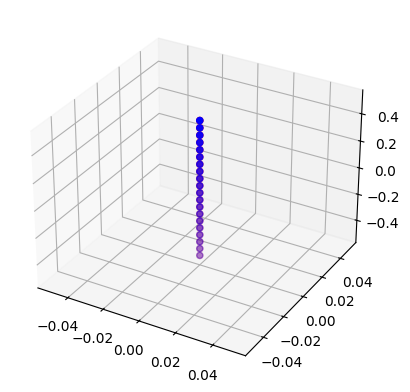

<Axes3D: >

In [101]:
print(ant)
ant.plot(backend='mpl')

In [102]:
ant.export_to_hdf5(OUTPUT_DIR + 'FW_sim.h5', overwrite=True)

2025/10/22 12:26:50 PM | INFO     | Overwriting existing "antenna" information
2025/10/22 12:26:50 PM | INFO     | File successfully saved in: c:\users\afsal\pycharmprojects\pythonproject14\fracwave\output\FW_sim.h5



## 4. Visualize the geometry configuration <a class="anchor" id="4"></a>
Check the geometry and check if everything is ok.

In [103]:
# We can visualize the geometry configuration with pyvista
import pyvista as pv
import pyvistaqt as pvqt

surf = frac.get_surface()
Tx, Rx, Tx_arrows, Rx_arrows = ant.get_geometry(show=False)

p = pvqt.BackgroundPlotter()
p.add_mesh(surf, color='white', opacity=0.5, show_edges=True)
p.add_mesh(Tx, color='red', point_size=10)
p.add_mesh(Rx, color='blue', point_size=10)
#p.add_mesh(Tx_arrows, color='red')
#p.add_mesh(Rx_arrows, color='blue')
p.show_bounds()
p.show_axes()


## 5. Setup the parameters for the forward simulation <a class="anchor" id="5"></a>
To run the forward simulation successfully, you must create an instance of the FracEM class and load all the necessary parameters for the simulation. If any errors occur during the process, make sure to double-check the Antenna, Source, and Fracture geometries. Ensure that these geometries are correctly defined and saved in the same file to ensure smooth execution of the simulation.

In [104]:
solv = FracEM()
solv.open_file(OUTPUT_DIR + 'FW_sim.h5')
print(solv)  # Check that all the fields are loaded correctly

2025/10/22 12:27:17 PM | INFO     | File correctly loaded. Ready to start.
 
            Effective-Dipole model  2025-10-22 12:27
            Calculating in: "reflection" mode
            Using: "SI" units
            
            Backend computation:
                engine: tensor_trace
                backend: numpy
                gpu: False
            
            Rock properties:
                sigma: None (S/m) 
                epsilon: None (F/m)
                velocity: 0.00000 (m/ns)
                center_frequency: 1.00 GHz
                wavelength: 0.00 (m)
            
            Calculating for:
                no. Profiles: 1
                no. Traces: 20
                no. Fractures: 1
                no. Elements (dipoles): 1600
                no. Frequencies: 1001
            
            Simulation:
                Time window: 100.16 (ns)
                Depth penetration: 0.00 (m) 
                    or for single hole: 0.00 (m)
                Time zero 

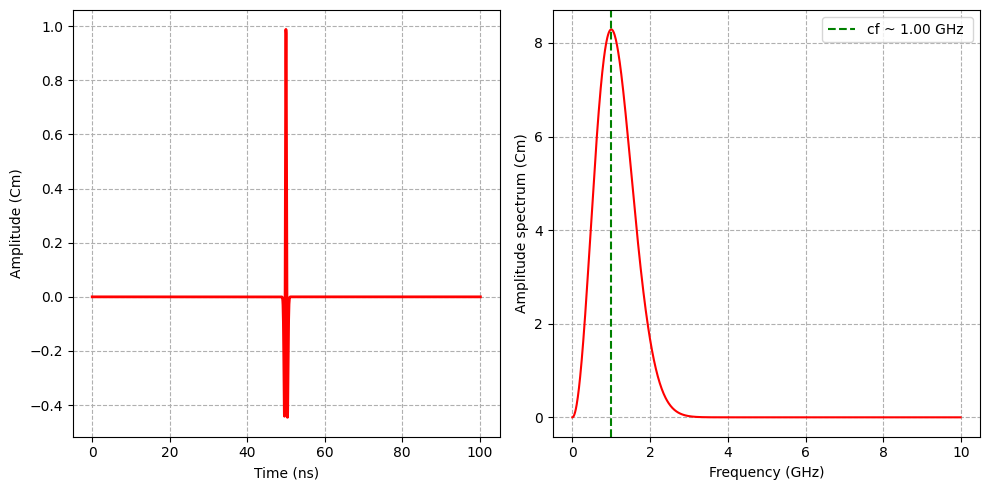

In [105]:
# Visualize the complete wavelet
sou2.plot_waveforms_complete()

In [106]:
# Now we can play with the different parameters
# TODO: This probably will change in the future but for now just replace the following values
solv.rock_epsilon = 9  # Electrical permittivity of the medium
solv.rock_sigma = 0  # Electrical conductivity of the medium
solv.backend = 'torch'  # You can choose between cupy, torch, numpy or dask (dask is for running parallel but maybe not working correctly). Cupy is to run in GPU. Numpy and torch are the most stable ones. We suggest to run torch since is the fastest one.
solv.engine='tensor_save'  # This is the engine that will be used to compute the simulation. Is also the most stable one. Don't try to choose another option if you are not sure what you are doing
solv.mode = 'reflection' # you can change to ['transmission', 'reflection', 'full_reflection', 'incoming_field', 'dipole_response', 'propagation'] depending on what you want to calculate
# 'propagation' is to calculate the propagation of the field to the fracture 
solv._fast_calculation_incoming_field = True  # This is a trick to speed up the calculation of the incoming field by calculating only the frequencies that have energy in the source function. We also skip some frequencies that don't contribute to the final result. Set to False to include all the frequencies and elements
solv.apply_causality = True # This is to check that the computations are inside the time window we are looking for. This means that it will filter out all those fracture elements that are too far from the antennas and will not show in the time window. Not calculating if _fast_calcualtion_incoming_field is False
solv.filter_fresnel = False  # This is to filter further the elements that are outside of the fresnel reflection zone

solv.filter_energy = False  # Here we focus on studying the incoming field on the fracture for a specific frequency and examine the propagating energy. To achieve this, we 
# apply a filtering process that eliminates the lower n% of energy across all fracture elements. This selective approach allows us to reduce computation time by excluding elements that have minimal impact on the final results.

solv._filter_percentage = 0.01  # This means that during the energy filtering process, any elements whose energy level is at or below 1% of the maximum energy among all elements will be excluded from our computation. By adjusting this filter percentage, we can control the level of filtering and fine-tune the simulation to strike a balance between computational efficiency and accuracy.


2025/10/22 12:27:34 PM | INFO     | 
Operative system: Windows 
Model name : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel 
    CPU core(s): 8
    Processes: 4
    Threads: 2
Memory:
    Total: 7.77 GiB
    Available: 979.71 MiB
    Used: 6.81 GiB (87.7%)
    Free: 979.71 MiB



## 6. Time zero correction <a class="anchor" id="6"></a>
To compensate for the time delay in our source function and achieve precise results, we implement a time zero correction. This process entails running a forward simulation, analyzing the time response, and comparing it to the actual distance. The entire correction process is automated, and the corrected time data is stored for future use. This corrected time will be employed to adjust the time vector in future simulations.


2025/10/22 12:27:42 PM | DEBUG    | Rx set
2025/10/22 12:27:42 PM | DEBUG    | Tx set
2025/10/22 12:27:42 PM | DEBUG    | orient_Rx set
2025/10/22 12:27:42 PM | DEBUG    | orient_Tx set
2025/10/22 12:27:42 PM | INFO     | Overwriting existing "antenna" information
2025/10/22 12:27:42 PM | INFO     | File successfully saved in: c:\users\afsal\pycharmprojects\pythonproject14\fracwave\data\time_correction/file.h5
2025/10/22 12:27:42 PM | INFO     | 
Operative system: Windows 
Model name : Intel64 Family 6 Model 140 Stepping 1, GenuineIntel 
    CPU core(s): 8
    Processes: 4
    Threads: 2
Memory:
    Total: 7.77 GiB
    Available: 821.73 MiB
    Used: 6.97 GiB (89.7%)
    Free: 821.73 MiB

2025/10/22 12:27:42 PM | INFO     | Propagation mode is selected. Geometry is not needed
2025/10/22 12:27:42 PM | INFO     | File correctly loaded. Ready to start.
 
            Time zero correction  2025-10-22 12:27
            Calculating in: "propagation" mode
            Using: "SI" units
        

  0%|          | 0/4 [00:00<?, ?it/s]

2025/10/22 12:27:43 PM | INFO     |  ------- End of Calculation. Elapsed time: 0:00:00.423726 ------- 
2025/10/22 12:27:43 PM | INFO     | ++++ "propagation" mode finished ++++
2025/10/22 12:27:43 PM | DEBUG    | Unique value found with name: simulation/mask_frequencies
2025/10/22 12:27:43 PM | DEBUG    | Unique value found with name: simulation/propagation
2025/10/22 12:27:43 PM | INFO     | 
+++++++++++++++++++++ End simulation +++++++++++++++++++++

+++++++++++++++++++++ Time elapsed: 0:00:00.755157 +++++++++++++++++++++

2025/10/22 12:27:43 PM | INFO     | No time zero correction
2025/10/22 12:27:43 PM | INFO     | Creating plot... If you don't want to display the plot then pass the argument 'show_plot=False'


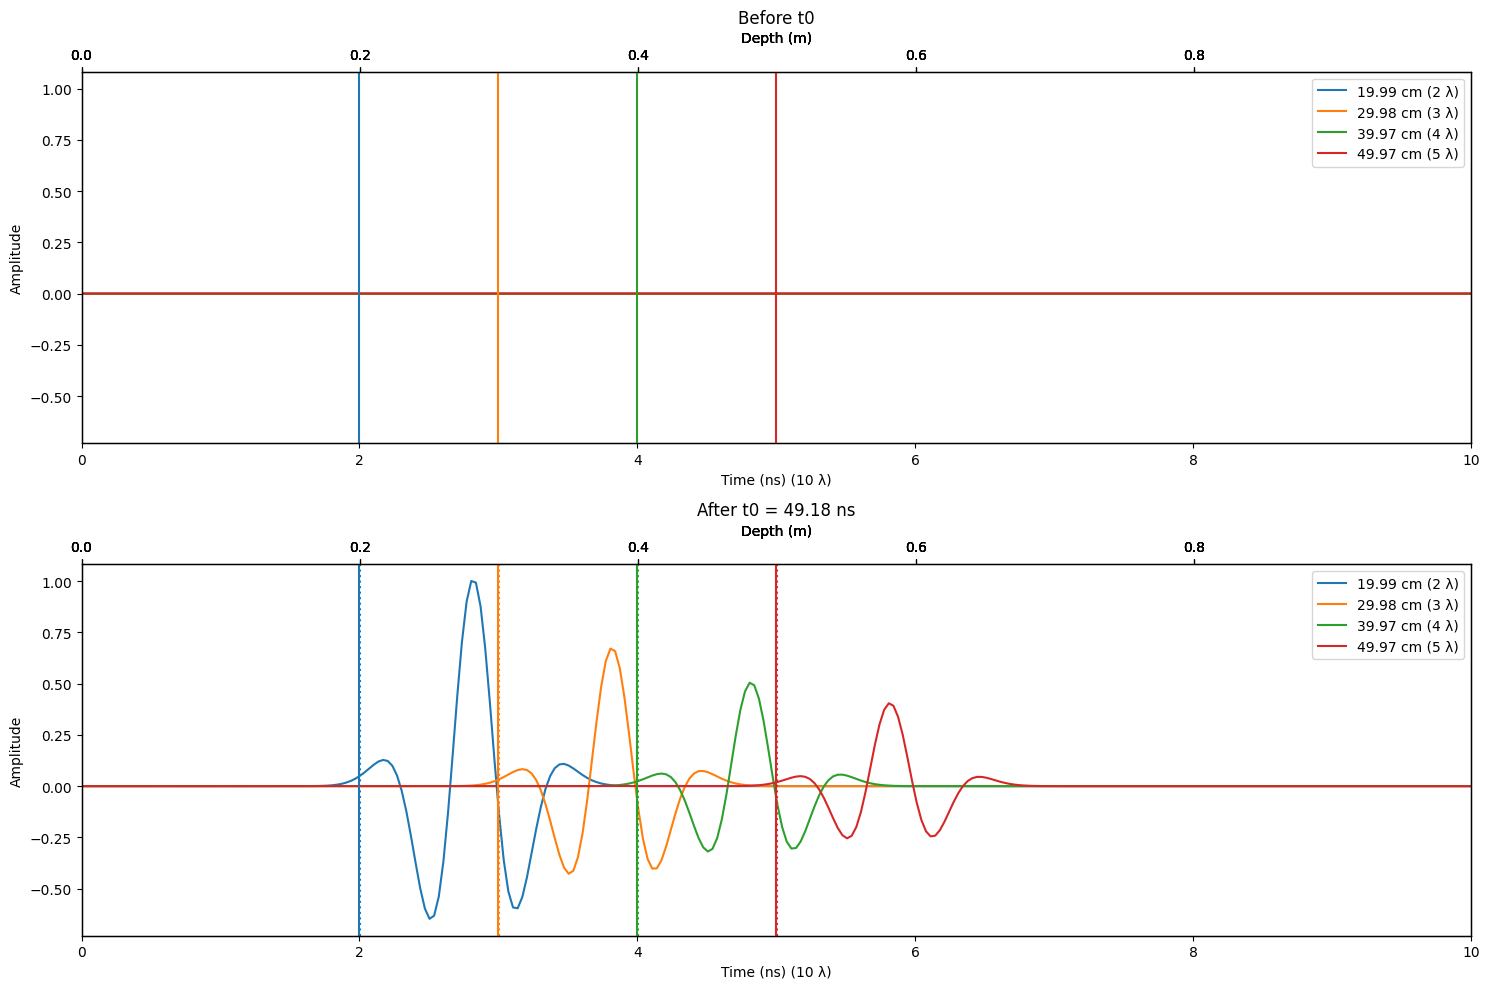

2025/10/22 12:27:51 PM | INFO     | "t0_correction" attribute created with 49.18 ns to remove

++++ 
We need to remove 49.18 ns to account for the time delay introduced when setting the source function 
++++ 



In [107]:
freqt = solv.time_zero_correction()
# if any errors, try adding a bigger time delay to the source function
print(f'\n++++ \nWe need to remove {solv._t0_correction:.2f} ns to account for the time delay introduced when setting the source function \n++++ \n')

## 7. Run the forward simulation <a class="anchor" id="7"></a>
Now we can run the forward simulation. This will take a while depending on the number of frequencies and the number of elements in the fracture. We have implemented a progress bar to see the progress of the simulation. 

In [109]:
freq = solv.forward_pass()

2025/10/22 12:28:23 PM | INFO     | 
+++++++++++++++++++++ Start Simulation. Mode: reflection +++++++++++++++++++++

2025/10/22 12:28:23 PM | DEBUG    | Unique value found with name: simulation/mask_frequencies
2025/10/22 12:28:23 PM | INFO     | Starting calculation for 20 amount of traces
2025/10/22 12:28:23 PM | DEBUG    | +++++++++ Calculating the mask at the fracture field +++++++++
2025/10/22 12:28:23 PM | DEBUG    | Using 63 frequencies out of 1001 possible
2025/10/22 12:28:23 PM | DEBUG    | +++++++++ Calculating causality +++++++++
2025/10/22 12:28:23 PM | DEBUG    | +++++++++ Done ++++++++++++++++++++++++++
2025/10/22 12:28:23 PM | INFO     | Using 357 frequencies out of 1001 possible frequencies
2025/10/22 12:28:23 PM | DEBUG    | Traces to calculate: 20 out of 20


  0%|          | 0/20 [00:00<?, ?it/s]

2025/10/22 12:28:48 PM | INFO     |  ------- End of Calculation. Elapsed time: 0:00:24.807163 ------- 
2025/10/22 12:28:48 PM | DEBUG    | Unique value found with name: simulation/mask_frequencies
2025/10/22 12:28:48 PM | DEBUG    | Unique value found with name: simulation/summed_response
2025/10/22 12:28:48 PM | INFO     | 
+++++++++++++++++++++ End simulation +++++++++++++++++++++

+++++++++++++++++++++ Time elapsed: 0:00:24.983725 +++++++++++++++++++++



## 8. Check results <a class="anchor" id="8"></a>
As we perform all calculations in the frequency domain, it's essential to convert the results back to the time domain. This transformation is achieved using the inverse Fourier transform. To simplify this process and apply the time zero correction, we have created a user-friendly function that handles both operations seamlessly. The time vector contains the corrected time vector accounting for the time correction. 

In [110]:
time_response, time_vector = solv.get_ifft(freq)

2025/10/22 12:28:55 PM | INFO     | Applying time zero correction to data. Removing 49.18 ns from data


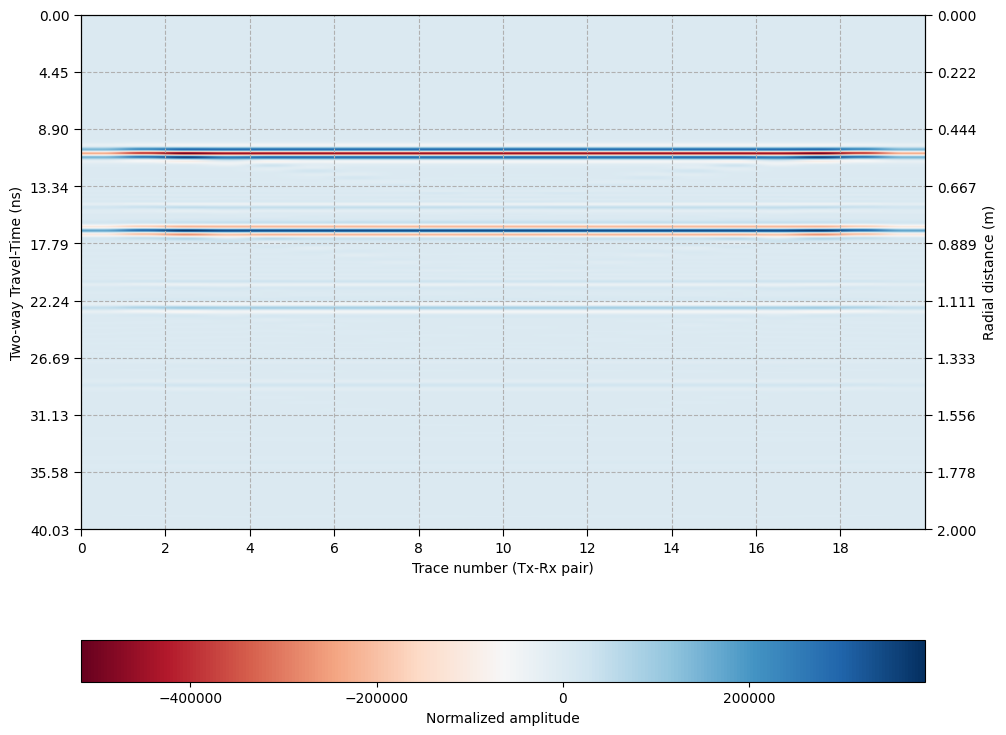

In [111]:
# Now we can visualize using matplotlib
time_response_n = time_response.T #/  np.max(np.abs(time_response))
fig, ax = plt.subplots(1,1, figsize=(10,8))

extent = (0, solv.ntraces, time_vector[-1], time_vector[0])
cax = ax.imshow(time_response_n, aspect='auto', cmap='RdBu', extent=extent)#, vmin=-1, vmax=1 )
ax.set_xlabel('Trace number (Tx-Rx pair)')
ax.set_ylabel('Two-way Travel-Time (ns)')

# ylims_d = (max(ylims)* solv.velocity * 0.5, min(ylims)* solv.velocity * 0.5)
ylims_d = (2,0)
# ylims = (300, 0)
ylims = (max(ylims_d) * 2 /  solv.velocity, min(ylims_d) * 2 / solv.velocity)
ax.set_ylim(ylims)

ax2 = ax.twinx()
ax2.set_ylim(ylims_d) # To account for the 2 way travel time
ax2.set_ylabel('Radial distance (m)')

ax.xaxis.set_ticks(np.arange(0, solv.ntraces, 2))

d_ticks = np.linspace(min(ylims_d), max(ylims_d), 10)
v_ticks = d_ticks * 2 / solv.velocity

ax.yaxis.set_ticks(v_ticks)
ax2.yaxis.set_ticks(d_ticks)

ax.tick_params(axis='both', which='both', direction='out', length=5)
ax2.tick_params(axis='both', which='both', direction='out', length=5)


ax.grid(linestyle='--')

plt.tight_layout(pad=0.5)
plt.colorbar(cax, ax=ax, label='Normalized amplitude', orientation='horizontal')
plt.show()

## 9. Save results <a class="anchor" id="9"></a>
The good news is that once you complete the forward calculation, the results are automatically saved. You can easily access and verify the saved files to ensure the data is there. Additionally, if you wish to revisit the results or perform further analysis, you have the option to load the saved data and plot it again. This flexibility enables you to conveniently review and explore the simulation outcomes whenever you need them.

In [154]:
solv = FracEM()
solv.load_hdf5(OUTPUT_DIR + 'FW_sim.h5')
print(solv)

2025/10/02 01:00:44 AM | INFO     | Loading file...
2025/10/02 01:00:45 AM | INFO     | File correctly loaded. Ready to start.
 
            Effective-Dipole model  2025-10-02 01:00
            Calculating in: "reflection" mode
            Using: "SI" units
            
            Backend computation:
                engine: tensor_trace
                backend: numpy
                gpu: False
            
            Rock properties:
                sigma: None (S/m) 
                epsilon: None (F/m)
                velocity: 0.00000 (m/ns)
                center_frequency: 1.00 GHz
                wavelength: 0.00 (m)
            
            Calculating for:
                no. Profiles: 1
                no. Traces: 20
                no. Fractures: 1
                no. Elements (dipoles): 1024
                no. Frequencies: 1001
            
            Simulation:
                Time window: 100.16 (ns)
                Depth penetration: 0.00 (m) 
                    or 

Loading all the information from the h5 file is remarkably convenient. Not only does it include the data, but also the attributes from all the geometry, antennas, sources, and simulation settings. This approach allows you to retrieve and access all the necessary details effortlessly, providing a seamless experience for reviewing and utilizing the simulation data.

In [155]:
freq2 = solv.file_read('summed_response')
assert np.allclose(freq, freq2), 'The results are not the same'

2025/10/02 01:00:56 AM | DEBUG    | Unique value found with name: simulation/summed_response


In [156]:
# You can conveniently see all the file structure here and load them in the same way.
solv.h5_tree()

Geometry files


<HDF5 file "FW_sim.h5" (mode r)>
├── antenna [Group] (5 items)
│   ├── Rx [Dataset: (20, 3)] - 240.00 B
│   ├── Tx [Dataset: (20, 3)] - 240.00 B
│   ├── orient_Rx [Dataset: (20, 3)] - 240.00 B
│   ├── orient_Tx [Dataset: (20, 3)] - 240.00 B
│   └── profiles [Group] (1 items)
│       └── Prof1 [Dataset: (20,)] - 80.00 B
├── mesh [Group] (2 items)
│   ├── geometry [Group] (10 items)
│   │   ├── area [Dataset: (1024,)] - 8.00 KiB
│   │   ├── azimuth [Dataset: (1024,)] - 8.00 KiB
│   │   ├── dip [Dataset: (1024,)] - 8.00 KiB
│   │   ├── faces [Dataset: (1024, 4)] - 16.00 KiB
│   │   ├── fractures [Group] (1 items)
│   │   │   └── Fracture1 [Dataset: (1024,)] - 4.00 KiB
│   │   ├── midpoint [Dataset: (1024, 3)] - 12.00 KiB
│   │   ├── nx [Dataset: (1024, 3)] - 24.00 KiB
│   │   ├── ny [Dataset: (1024, 3)] - 24.00 KiB
│   │   ├── nz [Dataset: (1024, 3)] - 24.00 KiB
│   │   └── vertices [Dataset: (1089, 3)] - 12.76 KiB
│   └── properties [Group] (3 items)
│       ├── aperture

In [ ]:
# If you want to load an specific attribute you can do it like this
solv.file_read_attribute('engine')  # We can skip the full path of the attribute as long it is not repeated in the file. Otherwise just use the full path 'simulation/engine'

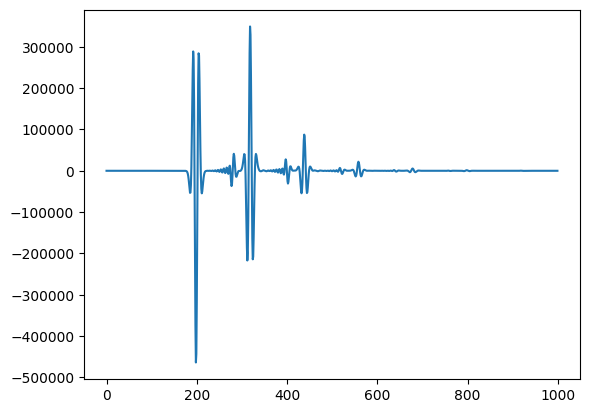

In [86]:
#print(time_response_n[1198])
plt.plot(time_response_n[1000:2000,10])
#print((time_response_n[1:1000,10]).mean())

In [33]:
a = np.array(time_response_n[1198,5:16])
mean_value = a.mean()
#median_value = a.median()
std_dev_value = a.std()
#descriptive_stats = a.describe()
print(mean_value)
#print(median_value)
print(std_dev_value)
#print(descriptive_stats)

-296362.35487546865
914.1149592405553
